In [1]:
import pickle
import warnings
import random
import umap
import torch

import numpy as np
import pandas as pd

from tqdm import tqdm
from glob import glob
from collections import OrderedDict
from scipy.spatial import distance, KDTree
from scipy import stats
from sklearn import decomposition
from IPython.display import display, Markdown

from torch.nn import functional as F

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import altair as alt
import seaborn as sns

mpl.style.use('seaborn-muted')
sns.set(style="whitegrid")

%matplotlib inline

In [3]:
warnings.simplefilter('ignore')
alt.data_transformers.enable('default', max_rows=None)
pd.options.display.max_rows = 500

In [4]:
embeds, rows = [], []

titles = set()

for path in tqdm(glob('../data/embeds-en/*.p')):
    with open(path, 'rb') as fh:
        
        lines = pickle.load(fh)

        for line in lines:
            
            title = ' '.join(line.pop('tokens'))
            
            if title not in titles:
                embeds.append(line.pop('embedding'))
                rows.append(OrderedDict(title=title, **line))
                titles.add(title)

100%|██████████| 65/65 [00:24<00:00,  2.69it/s]


In [5]:
embeds = np.stack(embeds)

In [6]:
df = pd.DataFrame(rows)

In [7]:
df.label.unique()

array(['apnews.com', 'washingtonpost.com', 'breitbart.com',
       'dailykos.com', 'nytimes.com', 'foxnews.com', 'bloomberg.com',
       'cnn.com', 'huffingtonpost.com', 'wsj.com', 'buzzfeed.com',
       'dailycaller.com', 'thehill.com'], dtype=object)

In [8]:
embeds.shape

(632221, 512)

In [9]:
df['p_true'] = df.apply(lambda r: r[f'p_{r.label}'], axis=1)

In [10]:
df['tip'] = df[['label', 'title']].apply(lambda x: f'{x[0]} - {x[1]}', axis=1)

# p-true distributions

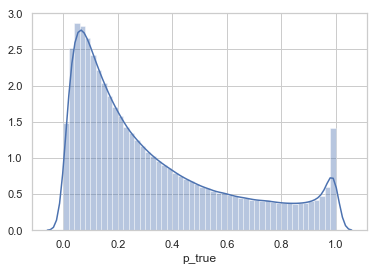

In [11]:
sns.distplot(df.p_true)

apnews.com


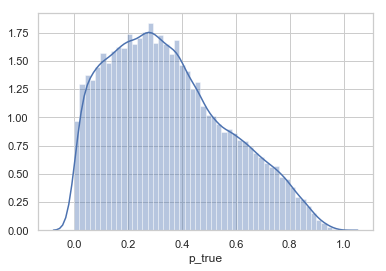

washingtonpost.com


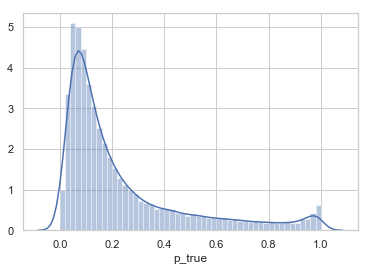

breitbart.com


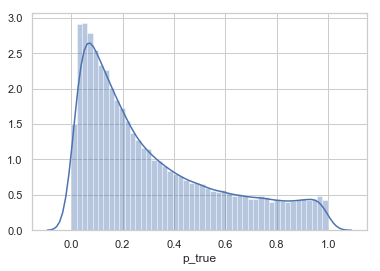

dailykos.com


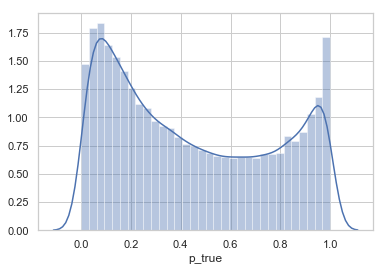

nytimes.com


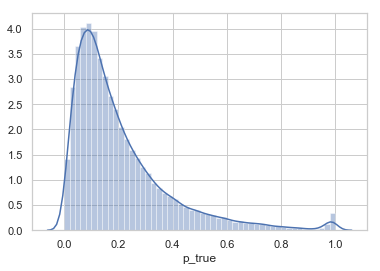

foxnews.com


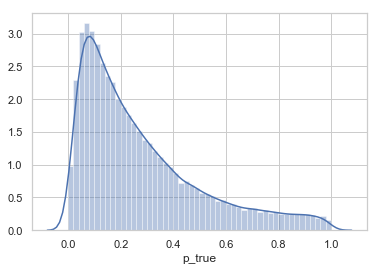

bloomberg.com


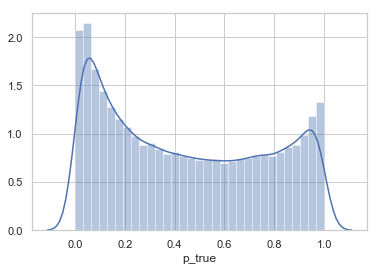

cnn.com


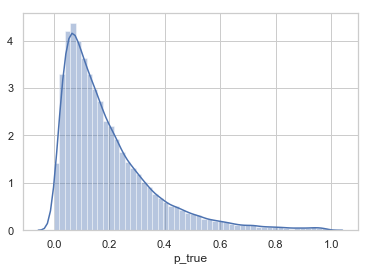

huffingtonpost.com


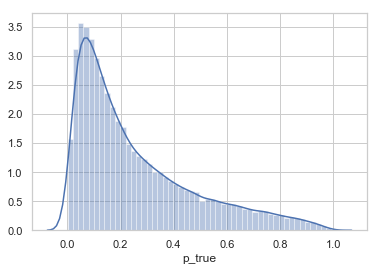

wsj.com


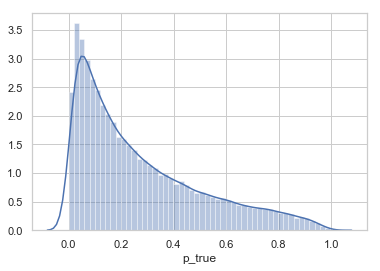

buzzfeed.com


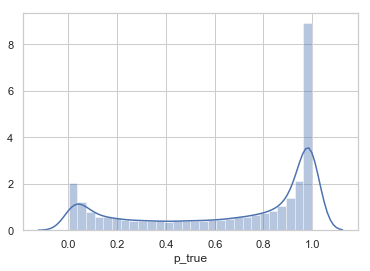

dailycaller.com


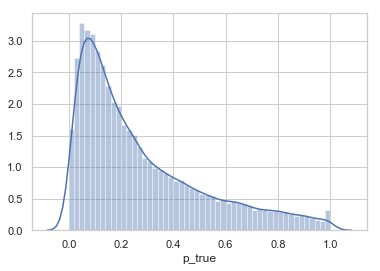

thehill.com


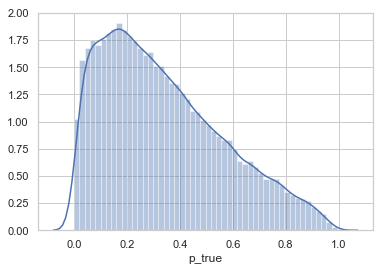

In [17]:
for d in df.label.unique():
    print(d)
#     plt.figure(figsize=(3,2))
    sns.distplot(df[df.label==d].p_true)
    plt.show()

In [13]:
df.sort_values('p_true', ascending=False)[['label', 'title', 'p_true', 'count']].head(20)

,label,title,p_true,count
426926,buzzfeed.com,pick some snacks and we ll reveal which austra...,1.000000,1
123181,buzzfeed.com,pick some food and we ll reveal which seventee...,1.000000,19
78318,buzzfeed.com,tell us your food preferences and we ll reveal...,1.000000,13
362936,buzzfeed.com,# times tumblr proved the english language was...,1.000000,28
138543,buzzfeed.com,pick some aesthetic pictures and we ll tell yo...,1.000000,3
6611,buzzfeed.com,answer these seven questions and we ll reveal ...,1.000000,3
328986,buzzfeed.com,# times british tumblr roasted the absolute sh...,0.999998,1
563275,buzzfeed.com,buy random things from target and we ll reveal...,0.999998,6
252674,buzzfeed.com,on this bollywood quiz you re probably vella af,0.999998,3
580060,buzzfeed.com,answer six random af questions and we ll revea...,0.999998,3


# p-true > 0.9

In [14]:
t10 = df[df.p_true > 0.9]
t10_embeds = embeds[t10.index]

dr = umap.UMAP(metric='cosine', verbose=True)
embedding = dr.fit_transform(t10_embeds)

UMAP(a=None, angular_rp_forest=False, b=None, init='spectral',
   learning_rate=1.0, local_connectivity=1.0, metric='cosine',
   metric_kwds=None, min_dist=0.1, n_components=2, n_epochs=None,
   n_neighbors=15, negative_sample_rate=5, random_state=None,
   repulsion_strength=1.0, set_op_mix_ratio=1.0, spread=1.0,
   target_metric='categorical', target_metric_kwds=None,
   target_n_neighbors=-1, target_weight=0.5, transform_queue_size=4.0,
   transform_seed=42, verbose=True)
Construct fuzzy simplicial set
	 0  /  15
	 1  /  15
	 2  /  15
	 3  /  15
	 4  /  15
Construct embedding
	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs


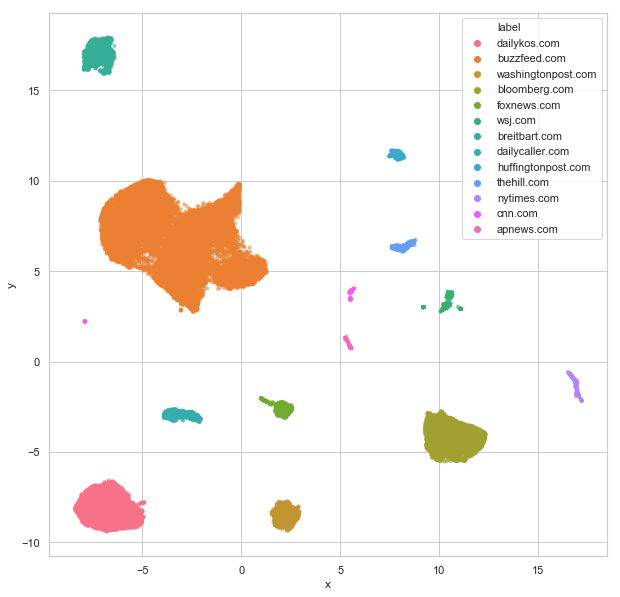

In [15]:
points = t10.copy()
points['x'] = embedding[:,0]
points['y'] = embedding[:,1]

points = points[['label', 'tip', 'p_true', 'x', 'y']]

plt.figure(figsize=(10,10))

sns.scatterplot(
    x='x', y='y',
    data=points,
    s=10,
    edgecolor=None,
    alpha=0.5,
    hue='label',
)

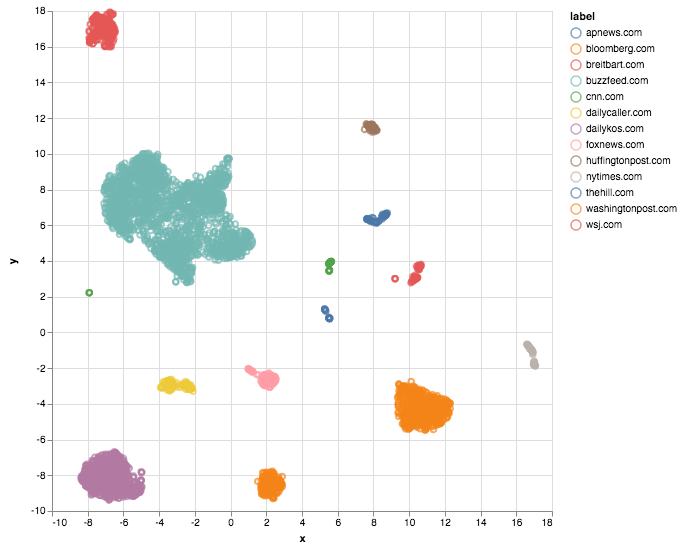

In [16]:
(alt
    .Chart(points.sample(frac=0.1), width=500, height=500)
    .mark_point()
    .encode(x='x', y='y', tooltip='tip', color='label'))